# Código

In [48]:
import pandas as pd
import numpy as np
from os import getcwd, remove, listdir
from os.path import join 
import matplotlib.pyplot as plt
from lvm_read import read
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.ar_model import AutoReg,ar_select_order
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.model_selection import (train_test_split, RepeatedKFold,
RandomizedSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

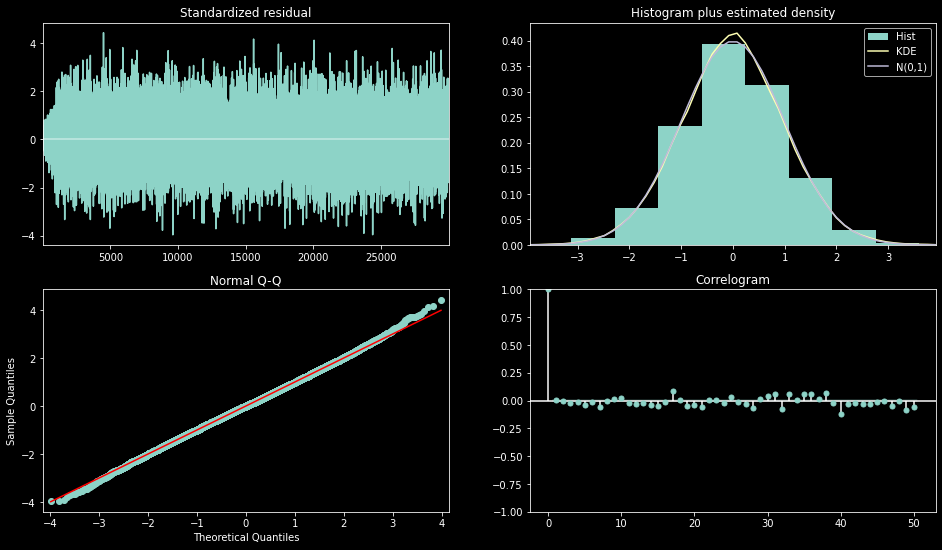

In [58]:
string="white_noise_"+str(1)+".lvm"
d=read(join(getcwd(),f'Case_R_(+25)/Case_R_(+25)_1/',string))
d[0]['Channel names'].pop()
df=pd.DataFrame(d[0]['data'],columns=d[0]['Channel names'])         
sel = ar_select_order(df["Ch2"],30)
sel.ar_lags
res = sel.model.fit()

fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=50)

In [2]:
# Params Download Data.
case_scheme = ["R","A","B","C","D","E","F","G","H","I","J","K","L"]
CH_numbers = 8
na = 17
df_AR = []
for jj, case in enumerate(case_scheme):
    [remove(join(getcwd(),f'Case_{case}_(+25)/Case_{case}_(+25)_1/',x)) for x in listdir(join(getcwd(),f'Case_{case}_(+25)/Case_{case}_(+25)_1/')) if '.pkl' in x]
    [remove(join(getcwd(),f'Case_{case}_(+25)/Case_{case}_(+25)_2/',x)) for x in listdir(join(getcwd(),f'Case_{case}_(+25)/Case_{case}_(+25)_2/')) if '.pkl' in x]
    for i in range(1, 41):
        if i > 20:
            ij = i-20
            sensor_scheme = "2"
        else:
            ij=i
            sensor_scheme ="1" # Sensor Scheme Choosed

        string="white_noise_"+str(ij)+".lvm"
        try:
            d=read(join(getcwd(),f'Case_{case}_(+25)/Case_{case}_(+25)_{sensor_scheme}/',string))
            d[0]['Channel names'].pop()
            df=pd.DataFrame(d[0]['data'],columns=d[0]['Channel names'])         
            ARmodel1 = AutoReg(df[f"Ch1"],na).fit()
            ARmodel2 = AutoReg(df[f"Ch2"],na).fit()
            ARmodel3 = AutoReg(df[f"Ch3"],na).fit()
            ARmodel4 = AutoReg(df[f"Ch4"],na).fit()
            ARmodel5 = AutoReg(df[f"Ch5"],na).fit()
            ARmodel6 = AutoReg(df[f"Ch6"],na).fit()
            ARmodel7 = AutoReg(df[f"Ch7"],na).fit()
            ARmodel8 = AutoReg(df[f"Ch8"],na).fit()
            ARparams=np.concatenate([ARmodel1.params,ARmodel2.params,ARmodel3.params,ARmodel4.params,
                                     ARmodel5.params,ARmodel6.params,ARmodel7.params,ARmodel8.params,[jj+1]])
            df_AR.append(ARparams)
        except:
            continue
df_AR=np.array(df_AR)


In [44]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

AttributeError: 'AutoRegResults' object has no attribute 'information'

<Figure size 864x432 with 0 Axes>

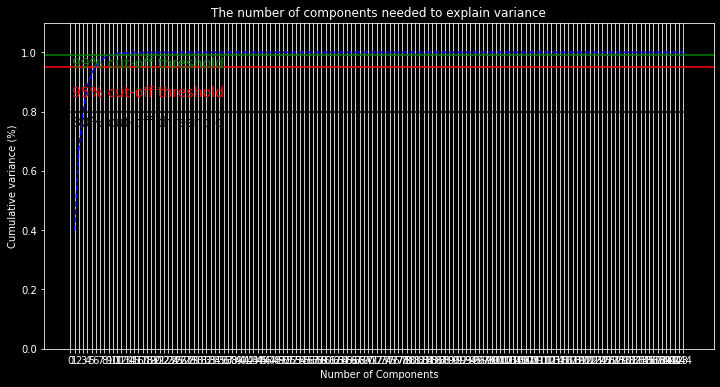

In [42]:
# PCA
pca = PCA().fit(df_AR[:,:-1])
plt.rcParams["figure.figsize"] = (12,6)
plt.figure()
fig, ax = plt.subplots()
exp_var = pca.explained_variance_ratio_
yi = np.cumsum(exp_var)
xi = np.arange(1, len(exp_var)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0,len(exp_var)+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=14)
plt.axhline(y=0.99, color='g', linestyle='-')
plt.text(0.5, 0.95, '99% cut-off threshold', color = 'green', fontsize=14)
plt.axhline(y=0.80, color='black', linestyle='-')
plt.text(0.5, 0.75, '80% cut-off threshold', color = 'black', fontsize=14)

ax.grid(axis='x')
plt.show()

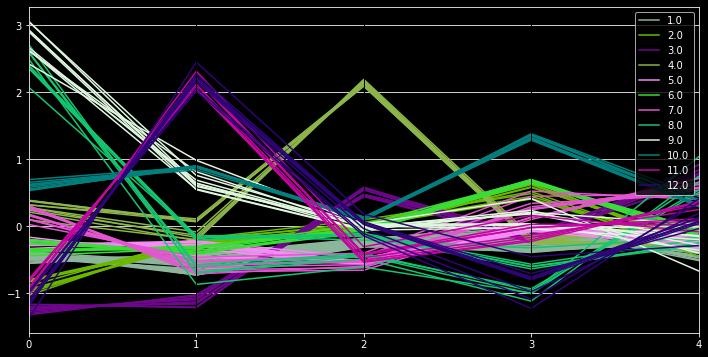

In [26]:
y_all = pd.DataFrame({'target':df_AR[:,-1]})
df_all_PCA = pd.DataFrame(PCA(n_components=5).fit_transform(df_AR[:,:-1]))#,columns=[f'{x} Component' for x in range(1,np.size(yi)+1)])
df_parallel = pd.concat([df_all_PCA,y_all],axis=1)
temp = [str(x) for x in df_parallel['target']]
df_parallel['target'] = temp
fig = pd.plotting.parallel_coordinates(df_parallel,"target") # px.parallel_coordinates(df_parallel,)


<AxesSubplot:xlabel='variable', ylabel='value'>

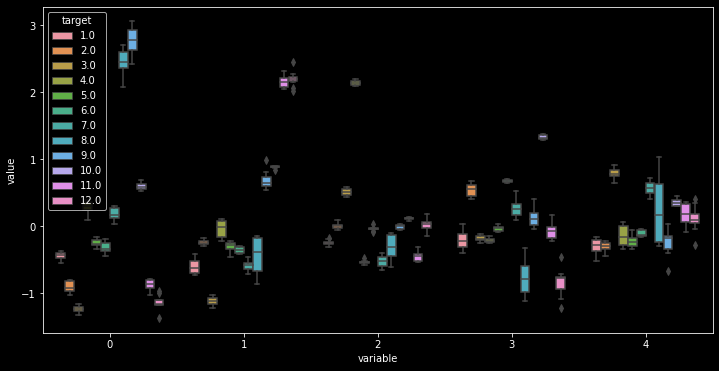

In [5]:
df_melted = df_parallel.melt(id_vars=['target'])
sns.boxplot(data = df_melted[df_melted['variable']<=10],x='variable',y='value',hue='target')

Text(0.5, 0.98, 'Dataset transformado por PCA e classificado pelo Label conhecido')

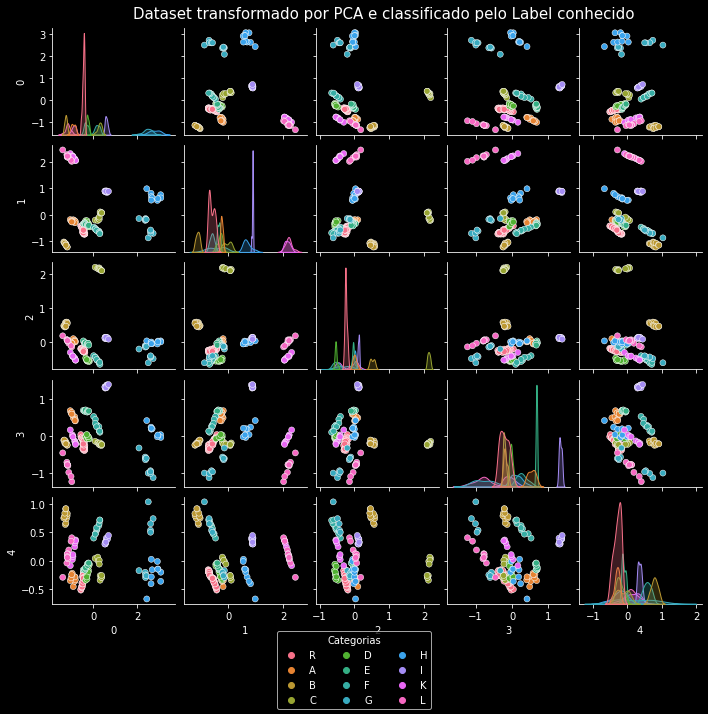

In [6]:
fig4=sns.pairplot(df_parallel,hue='target',height=2)
fig4._legend.remove()
handles = fig4._legend_data.values()
labels = case_scheme
fig4.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig4.fig.subplots_adjust(top=0.95, bottom=0.15)
fig4.fig.suptitle('Dataset transformado por PCA e classificado pelo Label conhecido',fontsize=15)

Text(0.5, 0.98, 'Dataset transformado por T-SNE e classificado pelo Label conhecido')

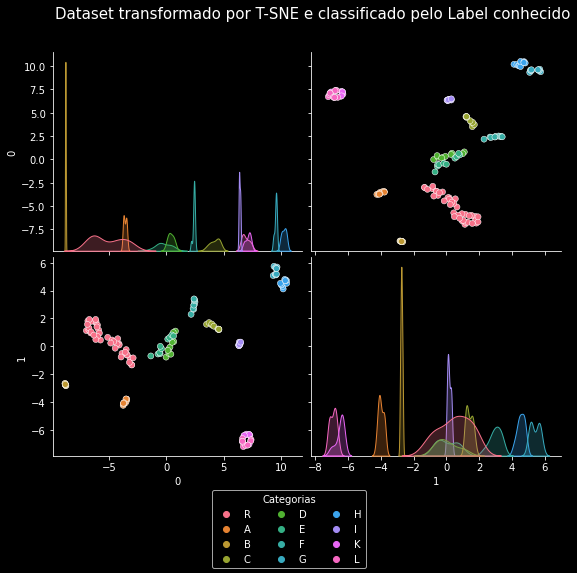

In [10]:
df_TSNE = pd.DataFrame(TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(df_parallel[df_parallel.columns[0:2]]))
df_TSNE = pd.concat([df_TSNE,df_parallel['target']],axis=1)
fig5=sns.pairplot(df_TSNE,hue='target',height=4)
fig5._legend.remove()
handles = fig5._legend_data.values()
labels = case_scheme
fig5.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig5.fig.subplots_adjust(top=0.9, bottom=0.2)
fig5.fig.suptitle('Dataset transformado por T-SNE e classificado pelo Label conhecido',fontsize=15)

In [13]:
models = []
models.append(("LRG",LogisticRegression()))
models.append(("SVC",SVC()))
models.append(("KNN",KNeighborsClassifier()))
models

[('LRG', LogisticRegression()),
 ('SVC', SVC()),
 ('KNN', KNeighborsClassifier())]

In [14]:
param_grids =[]
param_grids.append( #Softmax
    
        {
            "LRG__C":[1, 10, 20, 60, 70, 100],
            "LRG__solver" :[ 'lbfgs', 'liblinear', 'sag'],
            "LRG__multi_class":['multinomial']  
        }
    
)
param_grids.append( #SVC
    
        {
            "SVC__C"      : stats.loguniform(1e-1,1e3),
            "SVC__kernel" : ['linear','poly','rbf','sigmoid'],
            "SVC__degree" : stats.randint(2,5),
            "SVC__gamma"  : stats.loguniform(1e-4,1e0),
            #"SVC__epsilon"  : stats.loguniform(1e-4,1e1)
        }
    
)
param_grids.append( #KNN
    
        {
            "KNN__n_neighbors" : stats.randint(2,100),
            "KNN__weights"      : ["uniform","distance"],
            "KNN__algorithm" : [ "ball_tree", "kd_tree", "brute"],
            "KNN__leaf_size" : stats.randint(1,30)            
        }
    
)

In [36]:
kfolds = 5
nkiter = 50
n_iter = 100
acc=[]
cfmx =[]
best_params =[]
for i,md in enumerate(models):
    print(f'Iteração {i+1} - {md}\n')
    #Separar Data set em conjuntos de treino e teste ()
    train_x, test_x, train_y, test_y = train_test_split(df_TSNE[df_TSNE.columns[0:-1]], df_TSNE.target, test_size=0.3, random_state=0)

    rkf = RepeatedKFold(n_splits=kfolds,n_repeats=nkiter,random_state=0)

    clf = Pipeline([("scaler",StandardScaler()),(md)])

    param_grid = param_grids[i]

    #Cria modelo
    rnd_model = RandomizedSearchCV(clf,verbose=0,n_iter=n_iter,n_jobs=6,cv=rkf,
                                    random_state=1,param_distributions=param_grid,scoring=accuracy_score)
    rnd_model.fit(train_x,train_y)
    best_params.append(rnd_model.best_params_)
    yh_teste = rnd_model.predict(test_x)
    acc.append(accuracy_score(test_y, yh_teste,normalize=True))
    cfmx.append(confusion_matrix(test_y, yh_teste))
    print(f'Resultados: Acurácia={acc[i]}')
    print(f'Beste Params: {best_params[i]}\n')

Iteração 1 - ('LRG', LogisticRegression())

Resultados: Acurácia=0.6666666666666666
Beste Params: {'LRG__solver': 'lbfgs', 'LRG__multi_class': 'multinomial', 'LRG__C': 1}

Iteração 2 - ('SVC', SVC())

Resultados: Acurácia=0.7777777777777778
Beste Params: {'SVC__C': 4.656804637919565, 'SVC__degree': 2, 'SVC__gamma': 0.5373155847046793, 'SVC__kernel': 'poly'}

Iteração 3 - ('KNN', KNeighborsClassifier())

Resultados: Acurácia=0.7111111111111111
Beste Params: {'KNN__algorithm': 'kd_tree', 'KNN__leaf_size': 12, 'KNN__n_neighbors': 14, 'KNN__weights': 'uniform'}



[Text(0, 0.5, 'R'),
 Text(0, 1.5, 'A'),
 Text(0, 2.5, 'B'),
 Text(0, 3.5, 'C'),
 Text(0, 4.5, 'D'),
 Text(0, 5.5, 'E'),
 Text(0, 6.5, 'F'),
 Text(0, 7.5, 'G'),
 Text(0, 8.5, 'H'),
 Text(0, 9.5, 'I'),
 Text(0, 10.5, 'K'),
 Text(0, 11.5, 'L')]

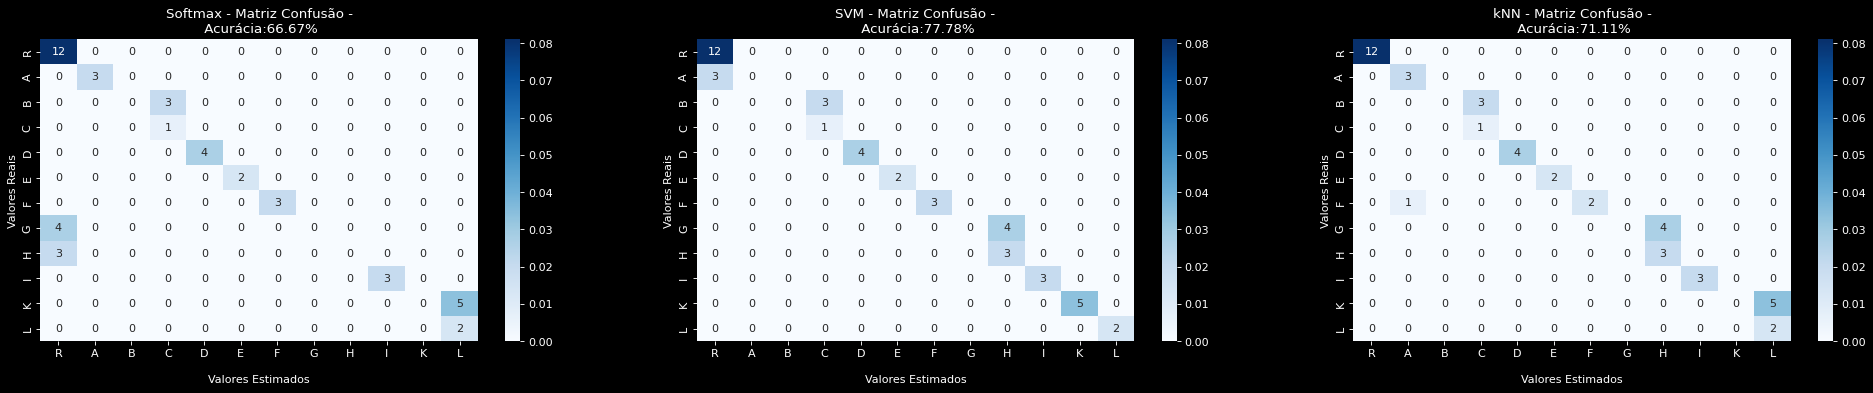

In [37]:
plt.figure(figsize=(30, 5), dpi=80)
plt.subplot(131)
group_counts_x1 = ["{0:0.0f}".format(value) for value in
                cfmx[0].flatten()]            
group_percentages_x1 = ["{0:.2%}".format(value) for value in
                     cfmx[0].flatten()/np.sum(cfmx[0])]                 
labels_x1 = [f"{v2}" for v2, v3 in
          zip(group_counts_x1,group_percentages_x1)]
labels_x1 = np.asarray(labels_x1).reshape(cfmx[0].shape)
ax1 = sns.heatmap(cfmx[0]/len(df_parallel['target']), annot=labels_x1,  cmap='Blues', fmt='')
ax1.set_title(f'Softmax - Matriz Confusão -\n Acurácia:{round(100*acc[0],2)}%')
ax1.set_xlabel('\nValores Estimados')
ax1.set_ylabel('Valores Reais')
## Ticket labels - List must be in alphabetical order
ax1.xaxis.set_ticklabels(case_scheme)
ax1.yaxis.set_ticklabels(case_scheme)

plt.subplot(132)
group_counts_x2 = ["{0:0.0f}".format(value) for value in
                cfmx[1].flatten()]            
group_percentages_x2 = ["{0:.2%}".format(value) for value in
                     cfmx[1].flatten()/np.sum(cfmx[1])]                 
labels_x2 = [f"{v2}" for v2, v3 in
          zip(group_counts_x2,group_percentages_x2)]
labels_x2 = np.asarray(labels_x2).reshape(cfmx[1].shape)
ax2 = sns.heatmap(cfmx[1]/len(df_parallel['target']), annot=labels_x2,  cmap='Blues', fmt='')
ax2.set_title(f'SVM - Matriz Confusão -\n Acurácia:{round(100*acc[1],2)}%')
ax2.set_xlabel('\nValores Estimados')
ax2.set_ylabel('Valores Reais')
## Ticket labels - List must be in alphabetical order
ax2.xaxis.set_ticklabels(case_scheme)
ax2.yaxis.set_ticklabels(case_scheme)

plt.subplot(133)
group_counts_x3 = ["{0:0.0f}".format(value) for value in
                cfmx[2].flatten()]            
group_percentages_x3 = ["{0:.2%}".format(value) for value in
                     cfmx[2].flatten()/np.sum(cfmx[2])]                 
labels_x3 = [f"{v2}" for v2, v3 in
          zip(group_counts_x3,group_percentages_x3)]
labels_x3 = np.asarray(labels_x3).reshape(cfmx[2].shape)
ax3 = sns.heatmap(cfmx[2]/len(df_parallel['target']), annot=labels_x3,  cmap='Blues', fmt='')
ax3.set_title(f'kNN - Matriz Confusão -\n Acurácia:{round(100*acc[2],2)}%')
ax3.set_xlabel('\nValores Estimados')
ax3.set_ylabel('Valores Reais')
## Ticket labels - List must be in alphabetical order
ax3.xaxis.set_ticklabels(case_scheme)
ax3.yaxis.set_ticklabels(case_scheme)

In [19]:
kfolds = 5
nkiter = 50
n_iter = 100
acc=[]
cfmx =[]
best_params =[]
for i,md in enumerate(models):
    print(f'Iteração {i+1} - {md}\n')
    #Separar Data set em conjuntos de treino e teste ()
    train_x, test_x, train_y, test_y = train_test_split(df_parallel[df_parallel.columns[0:-1]], df_parallel.target, test_size=0.3, random_state=0)

    rkf = RepeatedKFold(n_splits=kfolds,n_repeats=nkiter,random_state=0)

    clf = Pipeline([("scaler",StandardScaler()),(md)])

    param_grid = param_grids[i]

    #Cria modelo
    rnd_model = RandomizedSearchCV(clf,verbose=0,n_iter=n_iter,n_jobs=6,cv=rkf,
                                    random_state=1,param_distributions=param_grid,scoring=accuracy_score)
    rnd_model.fit(train_x,train_y)
    best_params.append(rnd_model.best_params_)
    yh_teste = rnd_model.predict(test_x)
    acc.append(accuracy_score(test_y, yh_teste,normalize=True))
    cfmx.append(confusion_matrix(test_y, yh_teste))
    print(f'Resultados: Acurácia={acc[i]}')
    print(f'Beste Params: {best_params[i]}\n')

Iteração 1 - ('LRG', LogisticRegression())

Resultados: Acurácia=0.9111111111111111
Beste Params: {'LRG__solver': 'lbfgs', 'LRG__multi_class': 'multinomial', 'LRG__C': 1}

Iteração 2 - ('SVC', SVC())

Resultados: Acurácia=1.0
Beste Params: {'SVC__C': 4.656804637919565, 'SVC__degree': 2, 'SVC__gamma': 0.5373155847046793, 'SVC__kernel': 'poly'}

Iteração 3 - ('KNN', KNeighborsClassifier())

Resultados: Acurácia=0.7111111111111111
Beste Params: {'KNN__algorithm': 'kd_tree', 'KNN__leaf_size': 12, 'KNN__n_neighbors': 14, 'KNN__weights': 'uniform'}



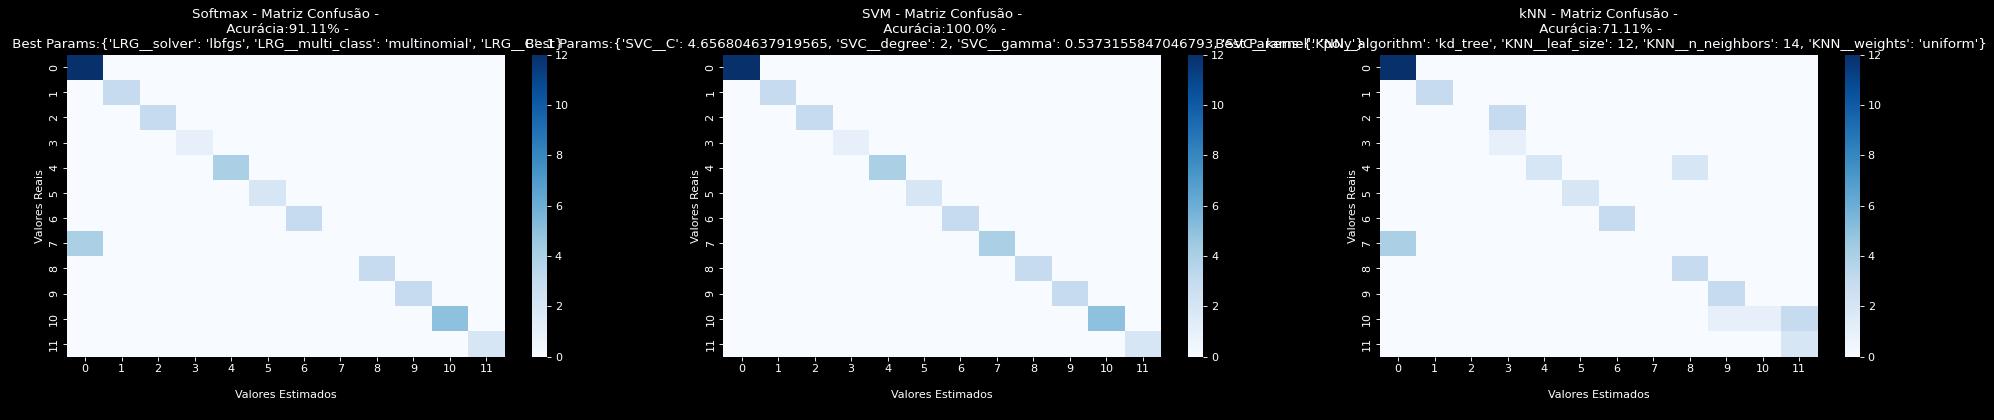

In [20]:
plt.figure(figsize=(30, 5), dpi=80)
plt.subplot(131)
ax0 = sns.heatmap(cfmx[0],  cmap='Blues')
ax0.set_title(f'Softmax - Matriz Confusão -\n Acurácia:{round(100*acc[0],2)}%')
ax0.set_xlabel('\nValores Estimados\n')
ax0.set_ylabel('Valores Reais')

plt.subplot(132)
ax1 = sns.heatmap(cfmx[1],  cmap='Blues')
ax1.set_title(f'SVM - Matriz Confusão -\n Acurácia:{round(100*acc[1],2)}%')
ax1.set_xlabel('\nValores Estimados\n')
ax1.set_ylabel('Valores Reais')

plt.subplot(133)
ax2 = sns.heatmap(cfmx[2],  cmap='Blues')
ax2.set_title(f'kNN - Matriz Confusão -\n Acurácia:{round(100*acc[2],2)}%')
ax2.set_xlabel('\nValores Estimados\n')
ax2.set_ylabel('Valores Reais')
plt.show()

[Text(0, 0.5, 'R'),
 Text(0, 1.5, 'A'),
 Text(0, 2.5, 'B'),
 Text(0, 3.5, 'C'),
 Text(0, 4.5, 'D'),
 Text(0, 5.5, 'E'),
 Text(0, 6.5, 'F'),
 Text(0, 7.5, 'G'),
 Text(0, 8.5, 'H'),
 Text(0, 9.5, 'I'),
 Text(0, 10.5, 'K'),
 Text(0, 11.5, 'L')]

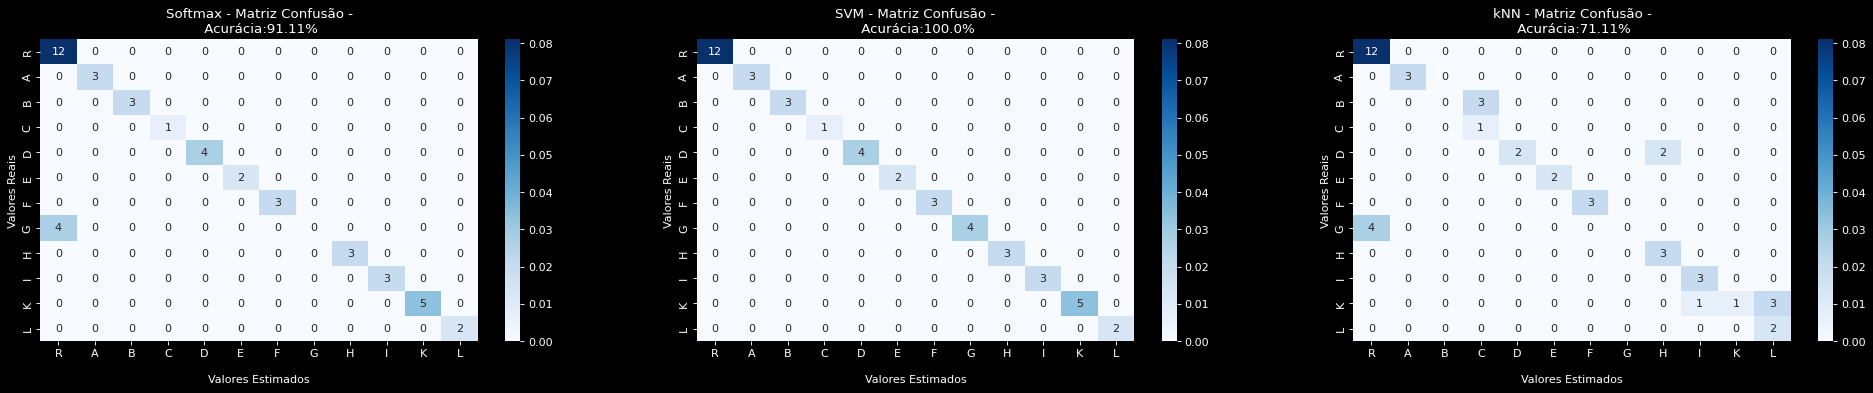

In [34]:
plt.figure(figsize=(30, 5), dpi=80)
plt.subplot(131)
group_counts_x1 = ["{0:0.0f}".format(value) for value in
                cfmx[0].flatten()]            
group_percentages_x1 = ["{0:.2%}".format(value) for value in
                     cfmx[0].flatten()/np.sum(cfmx[0])]                 
labels_x1 = [f"{v2}" for v2, v3 in
          zip(group_counts_x1,group_percentages_x1)]
labels_x1 = np.asarray(labels_x1).reshape(cfmx[0].shape)
ax1 = sns.heatmap(cfmx[0]/len(df_parallel['target']), annot=labels_x1,  cmap='Blues', fmt='')
ax1.set_title(f'Softmax - Matriz Confusão -\n Acurácia:{round(100*acc[0],2)}%')
ax1.set_xlabel('\nValores Estimados')
ax1.set_ylabel('Valores Reais')
## Ticket labels - List must be in alphabetical order
ax1.xaxis.set_ticklabels(case_scheme)
ax1.yaxis.set_ticklabels(case_scheme)

plt.subplot(132)
group_counts_x2 = ["{0:0.0f}".format(value) for value in
                cfmx[1].flatten()]            
group_percentages_x2 = ["{0:.2%}".format(value) for value in
                     cfmx[1].flatten()/np.sum(cfmx[1])]                 
labels_x2 = [f"{v2}" for v2, v3 in
          zip(group_counts_x2,group_percentages_x2)]
labels_x2 = np.asarray(labels_x2).reshape(cfmx[1].shape)
ax2 = sns.heatmap(cfmx[1]/len(df_parallel['target']), annot=labels_x2,  cmap='Blues', fmt='')
ax2.set_title(f'SVM - Matriz Confusão -\n Acurácia:{round(100*acc[1],2)}%')
ax2.set_xlabel('\nValores Estimados')
ax2.set_ylabel('Valores Reais')
## Ticket labels - List must be in alphabetical order
ax2.xaxis.set_ticklabels(case_scheme)
ax2.yaxis.set_ticklabels(case_scheme)

plt.subplot(133)
group_counts_x3 = ["{0:0.0f}".format(value) for value in
                cfmx[2].flatten()]            
group_percentages_x3 = ["{0:.2%}".format(value) for value in
                     cfmx[2].flatten()/np.sum(cfmx[2])]                 
labels_x3 = [f"{v2}" for v2, v3 in
          zip(group_counts_x3,group_percentages_x3)]
labels_x3 = np.asarray(labels_x3).reshape(cfmx[2].shape)
ax3 = sns.heatmap(cfmx[2]/len(df_parallel['target']), annot=labels_x3,  cmap='Blues', fmt='')
ax3.set_title(f'kNN - Matriz Confusão -\n Acurácia:{round(100*acc[2],2)}%')
ax3.set_xlabel('\nValores Estimados')
ax3.set_ylabel('Valores Reais')
## Ticket labels - List must be in alphabetical order
ax3.xaxis.set_ticklabels(case_scheme)
ax3.yaxis.set_ticklabels(case_scheme)